# EESHWAR VANNEMREDDY )

# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Extracting the zip files

In [2]:
import zipfile

In [3]:
with zipfile.ZipFile('CAN Bus log.zip','r') as zipp:
    zipp.extractall()

# Task 1: Data preparation


In [4]:
import pandas as pd
import regex as re

def extract_info(df):
    # splitting PID and its message
    def pid_split(pid_str):
        pid_keywords = '[^#]+'
        try:
            splitted_str = re.findall(pid_keywords, pid_str)
        except KeyError:
            splitted_str = pid_str
        return splitted_str

    # Splitting PID message into PID and message
    df[['PID', 'message']] = df['PID_info'].apply(lambda x: pd.Series(pid_split(x)))

    # Droping irrelevant information and selecting relevant PIDs 
    # 254 for Speed, 115 for RPM
    df = df.drop(['Bus_id', 'PID_info', 'Time_Stamp'], axis=1)
    df = df[df['PID'].isin(['254', '115'])]
    df['message'] = df['message'].str[-4:]
    df.reset_index(drop=True, inplace=True)

    # one hot encoding of PID and rename the columns
    df = pd.concat([df, pd.get_dummies(df['PID'])], axis=1).drop('PID', axis=1)
    df = df[['115', '254', 'message']].rename(columns={'115': 'RPM', '254': 'Speed'})

    return df



### Loading and extracting data from text files and droping ‘Attack’ column from dataframe

In [5]:
df0 = pd.read_csv("CAN bus log - no injection of messages.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])
df1 = pd.read_csv("CAN Bus log - injection of FFF as the speed reading.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])
df2 = pd.read_csv("CAN Bus log - injection of RPM readings.log", sep=" ", header=None, names=["Time_Stamp", "Bus_id", "PID_info"])

df0 = extract_info(df0)
df1 = extract_info(df1)
df2 = extract_info(df2)

import pandas as pd
import numpy as np

def getData(filename):
    canData = []  # List to store CAN data
    with open(filename, 'r') as f:
        for row in f:
            record = {
                'stamp': row[1:18],
                'PID': row[25:28],
                'const1': row[29:33],
                'change': row[33:41],
                'value': int(row[41:45], 16),
                'value2': 0,
                'attack': 0
            }
            if record["PID"] == '254':  # Processing of speed
                if record["value"] >= 4095:
                    record["attack"] = 1
                record['value'] = (record['value'] * 0.62137119) / 100
                canData.append(record)

            if record["PID"] == '115':  # Processing of RPM
                if record["value"] >= 65535:
                    record["attack"] = 1
                record['value'] = (record['value'] * 2)
                canData.append(record)

    return canData

def dict_to_df(data_dict):
    df = pd.DataFrame(data_dict)
    df = df.drop(columns=['stamp', 'const1', 'change', 'value2'])
    df = df[(df['PID'] == '115') | (df['PID'] == '254')]
    df = df.reset_index(drop=True)
    one_hot = pd.get_dummies(df['PID'])
    df = df.drop('PID', axis=1)
    df = df.join(one_hot)
    df = df[['115', '254', 'value']]
    df.rename(columns={'115': 'RPM', '254': 'Speed'}, inplace=True)
    df.loc[df['RPM'] == 1, 'RPM'] = df['value']
    df.loc[df['Speed'] == 1, 'Speed'] = df['value']
    df = df.drop(columns=['value'])
    return df

fff_injection_df = dict_to_df(getData("CAN Bus log - injection of FFF as the speed reading.log"))
rpm_injection_df = dict_to_df(getData("CAN Bus log - injection of RPM readings.log"))

# Drop 'Attack' column
if 'Attack' in df0:
    df0.drop('Attack', axis=1, inplace=True)

if 'Unnamed: 0' in df0:
    df0.drop('Unnamed: 0', axis=1, inplace=True)


# Task 2 - k-mean Clustering

### Scenario 1: CAN Bus log - No Injection of Messages (No Attack)

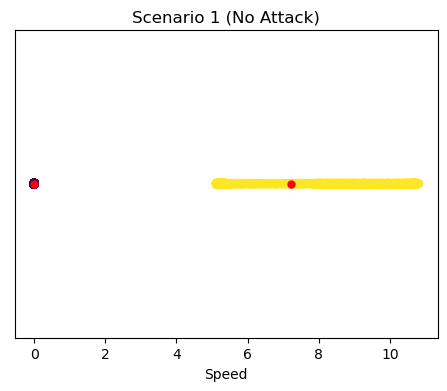

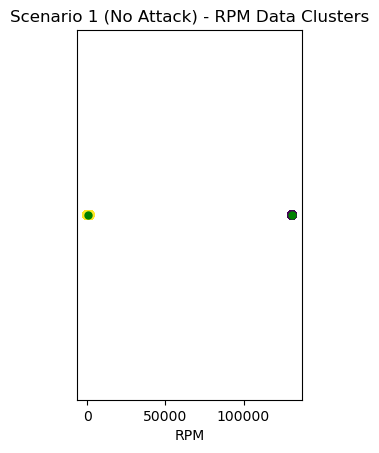

Scenario 1 (No Attack) - Speed Data Centroids: [[-1.77635684e-15]
 [ 7.22431579e+00]]
Scenario 1 (No Attack) - RPM Data Centroids: [[131070.        ]
 [   550.02207042]]


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the number of clusters (k as 2)
k = 2

# Perform K-means clustering for each scenario and dataset
datasets = [df0, fff_injection_df, rpm_injection_df]
dataset_names = ["Scenario 1 (No Attack)", "Scenario 2 (FFF Injection)", "Scenario 3 (RPM Injection)"]

for i, dataset in enumerate(datasets):
    # Extract Speed and RPM data
    speed_data = dataset['Speed'].values.reshape(-1, 1)
    rpm_data = dataset['RPM'].values.reshape(-1, 1)

# Initialize and fit K-means model for Speed
kmeans_speed = KMeans(n_clusters=k, random_state=0)
kmeans_speed.fit(speed_data)

# Initialize and fit K-means model for RPM
kmeans_rpm = KMeans(n_clusters=k, random_state=0)
kmeans_rpm.fit(rpm_data)

# Get cluster centers (centroids) for both Speed and RPM
centroids_speed = kmeans_speed.cluster_centers_
centroids_rpm = kmeans_rpm.cluster_centers_

# Visualize the fitted K-means clusters with scatter plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(speed_data, np.zeros_like(speed_data), c=kmeans_speed.labels_)
plt.scatter(centroids_speed, [0] * k, c='red', marker='.', s=100)
plt.title('Scenario 1 (No Attack)')
plt.xlabel('Speed')
plt.yticks([])
plt.show()

plt.subplot(1, 2, 2)
plt.scatter(rpm_data, np.zeros_like(rpm_data), c=kmeans_rpm.labels_)
plt.scatter(centroids_rpm, [0] * k, c='green', marker='.', s=100)
plt.title('Scenario 1 (No Attack) - RPM Data Clusters')
plt.xlabel('RPM')
plt.yticks([])
plt.show()

# Print centroids
print('Scenario 1 (No Attack) - Speed Data Centroids:', centroids_speed)
print('Scenario 1 (No Attack) - RPM Data Centroids:', centroids_rpm)


### Scenario 2: CAN Bus log - Injection of FFF as the speed reading

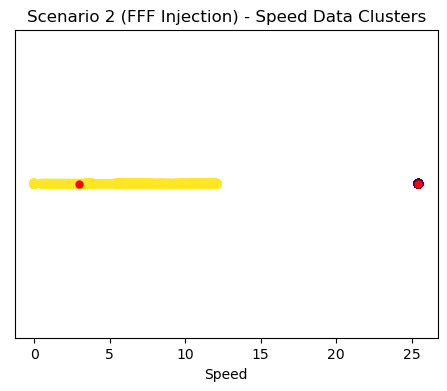

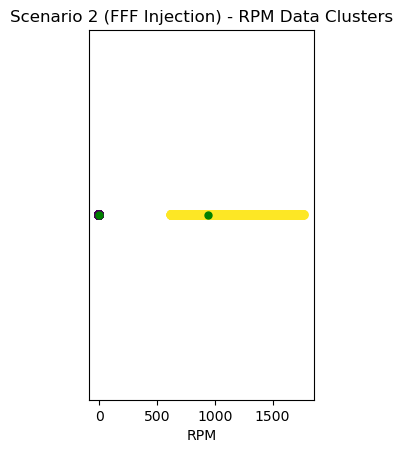

Scenario 2 (FFF Injection) - Speed Data Centroids: [[25.44515023]
 [ 2.95678584]]
Scenario 2 (FFF Injection) - RPM Data Centroids: [[5.59907676e-12]
 [9.45447747e+02]]


In [7]:
# Extract Speed and RPM data for Scenario 2 (FFF Injection)
speed_data = fff_injection_df['Speed'].values.reshape(-1, 1)
rpm_data = fff_injection_df['RPM'].values.reshape(-1, 1)

# Initialize and fit K-means model for Speed
kmeans_speed = KMeans(n_clusters=k, random_state=0)
kmeans_speed.fit(speed_data)

# Initialize and fit K-means model for RPM
kmeans_rpm = KMeans(n_clusters=k, random_state=0)
kmeans_rpm.fit(rpm_data)

# Get cluster centers (centroids) for both Speed and RPM
centroids_speed = kmeans_speed.cluster_centers_
centroids_rpm = kmeans_rpm.cluster_centers_

# Visualize the fitted K-means clusters with scatter plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(speed_data, np.zeros_like(speed_data), c=kmeans_speed.labels_)
plt.scatter(centroids_speed, [0] * k, c='red', marker='.', s=100)
plt.title('Scenario 2 (FFF Injection) - Speed Data Clusters')
plt.xlabel('Speed')
plt.yticks([])
plt.show()

plt.subplot(1, 2, 2)
plt.scatter(rpm_data, np.zeros_like(rpm_data), c=kmeans_rpm.labels_)
plt.scatter(centroids_rpm, [0] * k, c='green', marker='.', s=100)
plt.title('Scenario 2 (FFF Injection) - RPM Data Clusters')
plt.xlabel('RPM')
plt.yticks([])
plt.show()

# Print centroids
print('Scenario 2 (FFF Injection) - Speed Data Centroids:', centroids_speed)
print('Scenario 2 (FFF Injection) - RPM Data Centroids:', centroids_rpm)


### Scenario 3: CAN Bus log - Injection of RPM readings

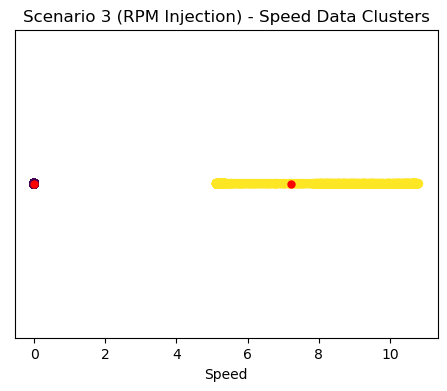

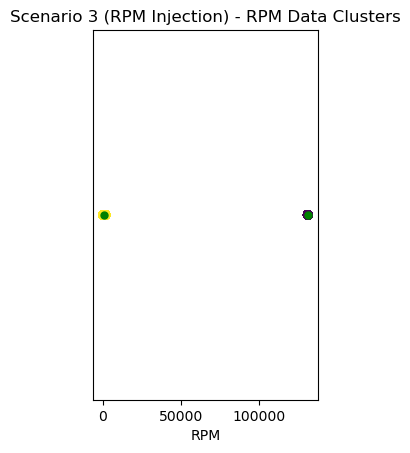

Scenario 3 (RPM Injection) - Speed Data Centroids: [[-1.77635684e-15]
 [ 7.22431579e+00]]
Scenario 3 (RPM Injection) - RPM Data Centroids: [[131070.        ]
 [   550.02207042]]


In [8]:
# Extract Speed and RPM data for Scenario 3 (RPM Injection)
speed_data = rpm_injection_df['Speed'].values.reshape(-1, 1)
rpm_data = rpm_injection_df['RPM'].values.reshape(-1, 1)

# Initialize and fit K-means model for Speed
kmeans_speed = KMeans(n_clusters=k, random_state=0)
kmeans_speed.fit(speed_data)

# Initialize and fit K-means model for RPM
kmeans_rpm = KMeans(n_clusters=k, random_state=0)
kmeans_rpm.fit(rpm_data)

# Get cluster centers (centroids) for both Speed and RPM
centroids_speed = kmeans_speed.cluster_centers_
centroids_rpm = kmeans_rpm.cluster_centers_

# Visualize the fitted K-means clusters with scatter plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(speed_data, np.zeros_like(speed_data), c=kmeans_speed.labels_)
plt.scatter(centroids_speed, [0] * k, c='red', marker='.', s=100)
plt.title('Scenario 3 (RPM Injection) - Speed Data Clusters')
plt.xlabel('Speed')
plt.yticks([])
plt.show()

plt.subplot(1, 2, 2)
plt.scatter(rpm_data, np.zeros_like(rpm_data), c=kmeans_rpm.labels_)
plt.scatter(centroids_rpm, [0] * k, c='green', marker='.', s=100)
plt.title('Scenario 3 (RPM Injection) - RPM Data Clusters')
plt.xlabel('RPM')
plt.yticks([])
plt.show()

# Print centroids
print('Scenario 3 (RPM Injection) - Speed Data Centroids:', centroids_speed)
print('Scenario 3 (RPM Injection) - RPM Data Centroids:', centroids_rpm)


# Task 3- Isolation Forest Algorithm

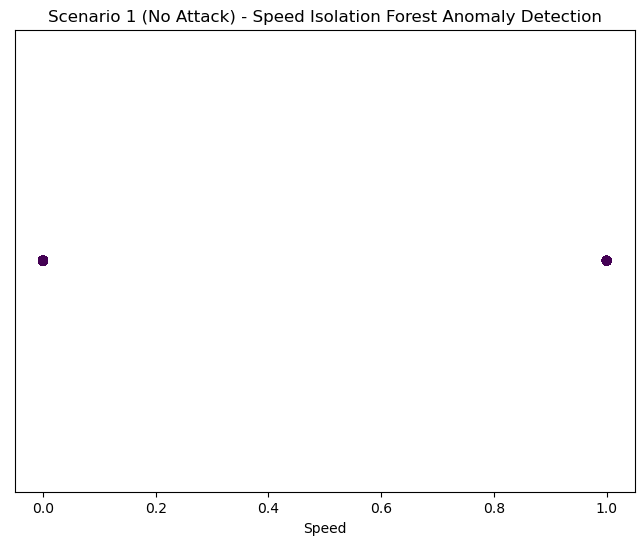

Anomaly Values in Scenario 1 (No Attack) (Speed):


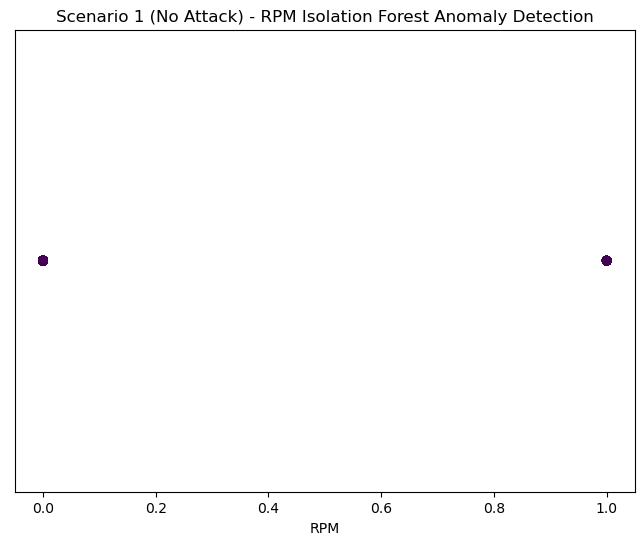

Anomaly Values in Scenario 1 (No Attack) (RPM):


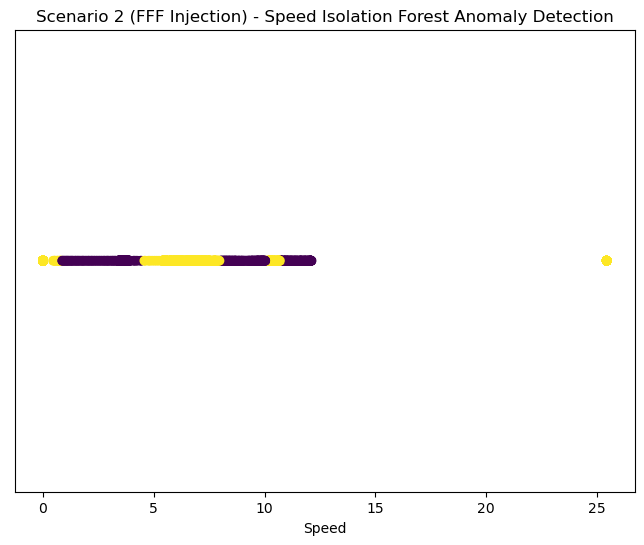

Anomaly Values in Scenario 2 (FFF Injection) (Speed):
Speed = 0.8699196659999999
Speed = 0.8699196659999999
Speed = 0.9382704969
Speed = 0.9382704969
Speed = 1.0128350396999999
Speed = 1.0128350396999999
Speed = 1.0811858706
Speed = 1.0811858706
Speed = 1.1495367015
Speed = 1.1495367015
Speed = 1.2178875323999998
Speed = 1.2551698037999999
Speed = 1.2924520751999997
Speed = 1.3235206347
Speed = 1.3608029061
Speed = 1.429153737
Speed = 1.4664360084
Speed = 1.4975045678999999
Speed = 1.5720691107
Speed = 1.5720691107
Speed = 1.6404199416
Speed = 1.677702213
Speed = 1.7460530439
Speed = 1.7771216034
Speed = 1.8144038748
Speed = 1.8516861462
Speed = 1.9200369770999999
Speed = 1.9573192485
Speed = 2.0256700793999998
Speed = 2.0567386388999997
Speed = 2.0940209103
Speed = 2.1623717412
Speed = 2.1996540126
Speed = 2.236936284
Speed = 2.3052871148999996
Speed = 2.3363556744
Speed = 2.4109202171999997
Speed = 2.4419887766999997
Speed = 2.5165533195
Speed = 2.547621879
Speed = 2.6159727099
Speed

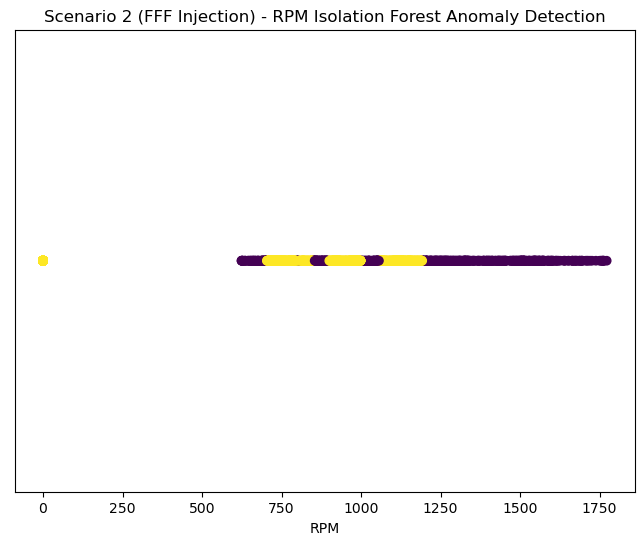

Anomaly Values in Scenario 2 (FFF Injection) (RPM):
RPM = 626.0
RPM = 624.0
RPM = 624.0
RPM = 626.0
RPM = 626.0
RPM = 626.0
RPM = 628.0
RPM = 628.0
RPM = 634.0
RPM = 634.0
RPM = 636.0
RPM = 636.0
RPM = 644.0
RPM = 644.0
RPM = 648.0
RPM = 648.0
RPM = 654.0
RPM = 654.0
RPM = 660.0
RPM = 660.0
RPM = 664.0
RPM = 664.0
RPM = 668.0
RPM = 668.0
RPM = 676.0
RPM = 676.0
RPM = 680.0
RPM = 680.0
RPM = 686.0
RPM = 686.0
RPM = 692.0
RPM = 692.0
RPM = 694.0
RPM = 694.0
RPM = 700.0
RPM = 862.0
RPM = 862.0
RPM = 880.0
RPM = 890.0
RPM = 890.0
RPM = 1006.0
RPM = 1006.0
RPM = 1010.0
RPM = 1014.0
RPM = 1024.0
RPM = 1024.0
RPM = 1028.0
RPM = 1032.0
RPM = 1040.0
RPM = 1040.0
RPM = 1042.0
RPM = 1042.0
RPM = 1050.0
RPM = 1048.0
RPM = 1048.0
RPM = 1048.0
RPM = 1052.0
RPM = 1048.0
RPM = 1050.0
RPM = 1050.0
RPM = 1054.0
RPM = 1054.0
RPM = 1054.0
RPM = 1054.0
RPM = 1050.0
RPM = 1050.0
RPM = 1038.0
RPM = 1032.0
RPM = 1024.0
RPM = 1024.0
RPM = 1014.0
RPM = 1000.0
RPM = 888.0
RPM = 888.0
RPM = 872.0
RPM = 872.0
RPM 

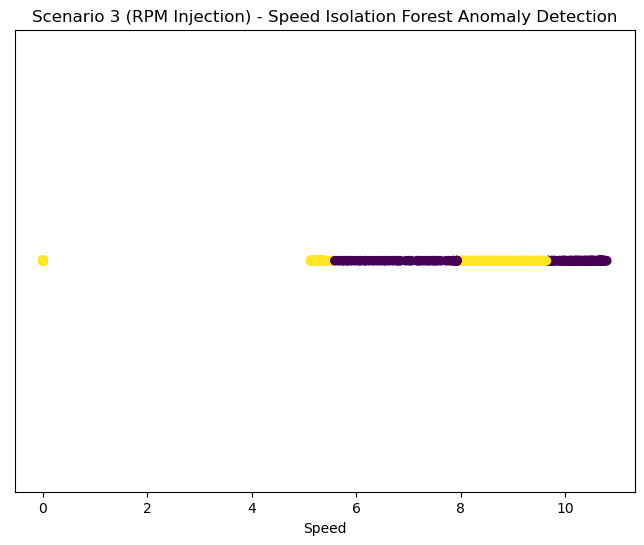

Anomaly Values in Scenario 3 (RPM Injection) (Speed):
Speed = 5.592340709999999
Speed = 5.6606915409
Speed = 5.7290423718
Speed = 5.766324643199999
Speed = 5.834675474099999
Speed = 5.834675474099999
Speed = 5.903026305
Speed = 5.9713771359
Speed = 6.0459416787
Speed = 6.0770102382
Speed = 6.151574780999999
Speed = 6.1826433405
Speed = 6.2509941714
Speed = 6.3255587142000005
Speed = 6.393909545099999
Speed = 6.462260376
Speed = 6.5306112069
Speed = 6.5678934783
Speed = 6.6362443092
Speed = 6.710808852
Speed = 6.779159682899999
Speed = 6.8102282424
Speed = 6.8475105138
Speed = 6.9531436161
Speed = 7.021494447
Speed = 7.0587767184
Speed = 7.164409820699999
Speed = 7.1954783802
Speed = 7.2327606516
Speed = 7.3011114825
Speed = 7.3694623134
Speed = 7.4067445848
Speed = 7.4750954157
Speed = 7.5123776871
Speed = 7.549659958499999
Speed = 7.6180107893999995
Speed = 7.7236438917
Speed = 7.7919947226
Speed = 7.8603455535
Speed = 7.8603455535
Speed = 7.8603455535
Speed = 9.6809631402
Speed = 9.7

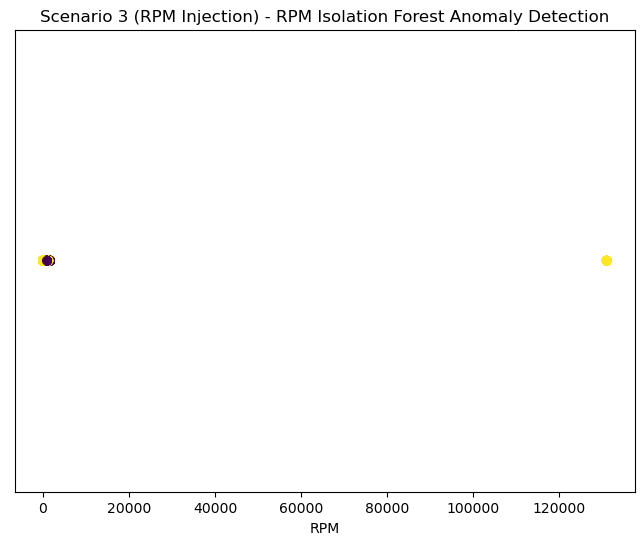

Anomaly Values in Scenario 3 (RPM Injection) (RPM):
RPM = 716.0
RPM = 716.0
RPM = 706.0
RPM = 706.0
RPM = 706.0
RPM = 706.0
RPM = 712.0
RPM = 716.0
RPM = 716.0
RPM = 724.0
RPM = 724.0
RPM = 782.0
RPM = 800.0
RPM = 800.0
RPM = 814.0
RPM = 814.0
RPM = 844.0
RPM = 880.0
RPM = 880.0
RPM = 1284.0
RPM = 1316.0
RPM = 1350.0
RPM = 1368.0
RPM = 1390.0
RPM = 1420.0
RPM = 1430.0
RPM = 1446.0
RPM = 1466.0
RPM = 1474.0
RPM = 1484.0
RPM = 1510.0
RPM = 1514.0
RPM = 1524.0
RPM = 1530.0
RPM = 1534.0
RPM = 1550.0
RPM = 1558.0
RPM = 1568.0
RPM = 1570.0
RPM = 1574.0
RPM = 1588.0
RPM = 1582.0
RPM = 1594.0
RPM = 1596.0
RPM = 1598.0
RPM = 1606.0
RPM = 1606.0
RPM = 1606.0
RPM = 1596.0
RPM = 1592.0
RPM = 1600.0
RPM = 1598.0
RPM = 1598.0
RPM = 1596.0
RPM = 1594.0
RPM = 1606.0
RPM = 1600.0
RPM = 1602.0
RPM = 1602.0
RPM = 1602.0
RPM = 1612.0
RPM = 1606.0
RPM = 1614.0
RPM = 1616.0
RPM = 1616.0
RPM = 1626.0
RPM = 1618.0
RPM = 1620.0
RPM = 1622.0
RPM = 1620.0
RPM = 1632.0
RPM = 1620.0
RPM = 1620.0
RPM = 1610.0
RPM =

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Define contamination (proportion of outliers)
contamination = 0.05  # You can adjust this value based on your dataset and anomaly detection needs

# Create a function for anomaly detection and plotting
def detect_anomalies_and_plot(data, data_name, dataset_name):
    # Initialize and fit Isolation Forest model
    isolation_forest = IsolationForest(contamination=contamination, random_state=0)
    isolation_forest.fit(data)

    # Predict anomalies
    anomalies = isolation_forest.predict(data)

    # Get the indices of anomalies
    anomaly_indices = np.where(anomalies == -1)[0]

    # Get the values of anomalies
    anomaly_values = data[anomaly_indices]

    # Visualize the fitted Isolation Forest clusters with scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(data, np.zeros_like(data), c=anomalies)
    plt.title(f'{dataset_name} - {data_name} Isolation Forest Anomaly Detection')
    plt.xlabel(data_name)
    plt.yticks([])

    plt.show()

    # Print anomaly values
    print(f'Anomaly Values in {dataset_name} ({data_name}):')
    for value in anomaly_values:
        print(f'{data_name} = {value[0]}')

# Perform anomaly detection and plotting for each scenario and dataset
datasets = [df0, fff_injection_df, rpm_injection_df]
dataset_names = ["Scenario 1 (No Attack)", "Scenario 2 (FFF Injection)", "Scenario 3 (RPM Injection)"]
data_names = ["Speed", "RPM"]

for i, dataset in enumerate(datasets):
    dataset_name = dataset_names[i]
    for j, data_name in enumerate(data_names):
        data = dataset[data_name].values.reshape(-1, 1)
        detect_anomalies_and_plot(data, data_name, dataset_name)


### Scenario 1: CAN Bus log - No Injection of Messages (No Attack)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


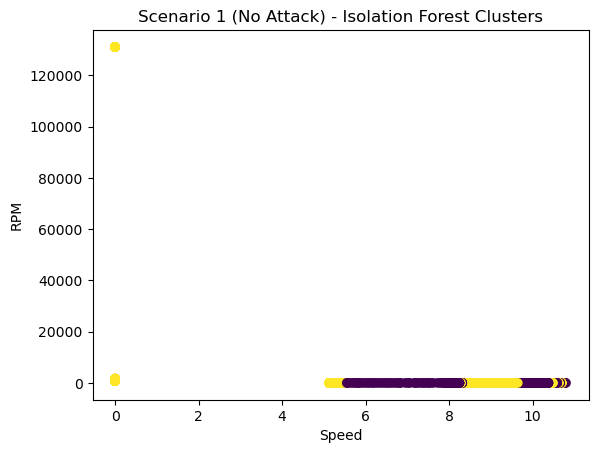

Anomalies detected in Scenario 1:
      RPM     Speed  anomaly
2025  0.0  5.555058       -1
2032  0.0  5.555058       -1
2039  0.0  5.592341       -1
2044  0.0  5.660692       -1
2051  0.0  5.729042       -1
...   ...       ...      ...
4513  0.0  7.928696       -1
4519  0.0  7.928696       -1
4527  0.0  7.928696       -1
4532  0.0  7.928696       -1
4538  0.0  7.928696       -1

[221 rows x 3 columns]


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

datasets = [df0, fff_injection_df, rpm_injection_df]
dataset_names = ["Scenario 1 (No Attack)", "Scenario 2 (FFF Injection)", "Scenario 3 (RPM Injection)"]

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.05)  
model.fit(dataset[["Speed"]])  

# Predict anomalies
dataset["anomaly"] = model.predict(dataset[["Speed"]])

# Scatter plot to visualize clusters
plt.scatter(dataset["Speed"], dataset["RPM"], c=dataset["anomaly"], cmap='viridis')
plt.title("Scenario 1 (No Attack) - Isolation Forest Clusters")
plt.xlabel("Speed")
plt.ylabel("RPM")
plt.show()

# Print anomalies
anomalies = dataset[dataset["anomaly"] == -1]
print("Anomalies detected in Scenario 1:")
print(anomalies)


### Scenario 2: CAN Bus log - Injection of FFF as the speed reading

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


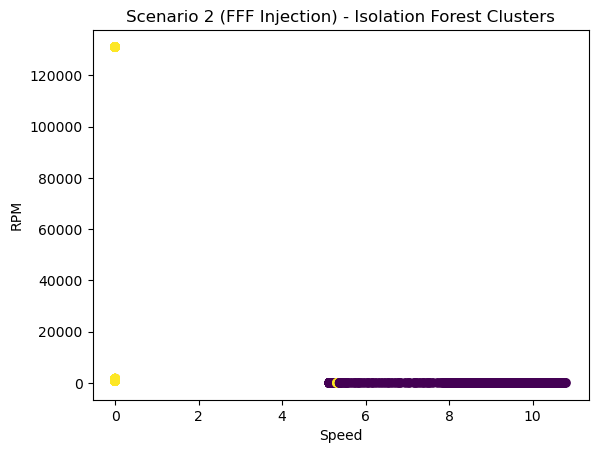

Anomalies detected in Scenario 2:
      RPM     Speed  anomaly
45    0.0  5.275441       -1
50    0.0  5.275441       -1
52    0.0  5.275441       -1
54    0.0  5.275441       -1
57    0.0  5.275441       -1
...   ...       ...      ...
4513  0.0  7.928696       -1
4519  0.0  7.928696       -1
4527  0.0  7.928696       -1
4532  0.0  7.928696       -1
4538  0.0  7.928696       -1

[622 rows x 3 columns]


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

datasets = [df0, fff_injection_df, rpm_injection_df]
dataset_names = ["Scenario 1 (No Attack)", "Scenario 2 (FFF Injection)", "Scenario 3 (RPM Injection)"]

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.15)  
model.fit(dataset[["Speed"]])  

# Predict anomalies
dataset["anomaly"] = model.predict(dataset[["Speed"]])

# Scatter plot to visualize clusters
plt.scatter(dataset["Speed"], dataset["RPM"], c=dataset["anomaly"], cmap='viridis')
plt.title("Scenario 2 (FFF Injection) - Isolation Forest Clusters")
plt.xlabel("Speed")
plt.ylabel("RPM")
plt.show()

# Print anomalies
anomalies = dataset[dataset["anomaly"] == -1]
print("Anomalies detected in Scenario 2:")
print(anomalies)

### Scenario 3: CAN Bus log - Injection of RPM readings

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


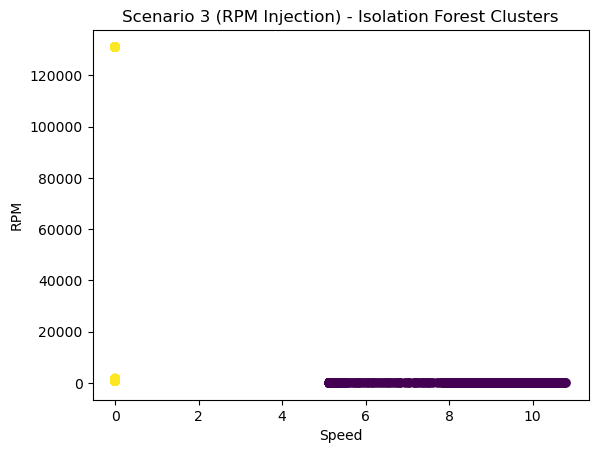

Anomalies detected in Scenario 3:
      RPM     Speed  anomaly
1     0.0  5.312724       -1
3     0.0  5.312724       -1
5     0.0  5.312724       -1
8     0.0  5.343792       -1
10    0.0  5.343792       -1
...   ...       ...      ...
4513  0.0  7.928696       -1
4519  0.0  7.928696       -1
4527  0.0  7.928696       -1
4532  0.0  7.928696       -1
4538  0.0  7.928696       -1

[816 rows x 3 columns]


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

datasets = [df0, fff_injection_df, rpm_injection_df]
dataset_names = ["Scenario 1 (No Attack)", "Scenario 2 (FFF Injection)", "Scenario 3 (RPM Injection)"]

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.25)  
model.fit(dataset[["Speed"]])  

# Predict anomalies
dataset["anomaly"] = model.predict(dataset[["Speed"]])

# Scatter plot to visualize clusters
plt.scatter(dataset["Speed"], dataset["RPM"], c=dataset["anomaly"], cmap='viridis')
plt.title("Scenario 3 (RPM Injection) - Isolation Forest Clusters")
plt.xlabel("Speed")
plt.ylabel("RPM")
plt.show()

# Print anomalies
anomalies = dataset[dataset["anomaly"] == -1]
print("Anomalies detected in Scenario 3:")
print(anomalies)

# Task 4 - Hidden Markov Models

In [13]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [14]:
from hmmlearn import hmm
import pandas as pd

def hidden_markov_model(df):
    # Extract the relevant feature(s) from the DataFrame for modeling
    data = df[['Speed']].values  # Modify 'Speed' to the name of the feature you want to use

    # Define the number of hidden states in the HMM
    n_states = 2  # You want to distinguish between "Attack" and "No Attack"

    # Create and fit the HMM model
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
    model.fit(data)

    # Predict the most likely sequence of internal hidden state
    hidden_states = model.predict(data)
    
    # Determine if it's an "Attack" or "No Attack" based on the HMM prediction
    # You may need to adjust this based on the mapping of hidden states to labels
    predicted_labels = ['Attack' if state == 0 else 'No Attack' for state in hidden_states]

    # Add the predicted labels to the DataFrame
    df['Predicted_Label'] = predicted_labels

    return df

# Assuming you have DataFrames df0, df1, and df2 with an 'Attack' label column
df0 = hidden_markov_model(df0)
df1 = hidden_markov_model(df1)
df2 = hidden_markov_model(df2)

# Print the modified DataFrames with the 'Predicted_Label' column
print(df0)
print(df1)
print(df2)


      RPM  Speed message Predicted_Label
0       1      0    013E          Attack
1       0      1    0000          Attack
2       1      0    0140          Attack
3       0      1    0000          Attack
4       1      0    0140          Attack
...   ...    ...     ...             ...
1644    1      0    015F          Attack
1645    1      0    015F          Attack
1646    0      1    01E9          Attack
1647    1      0    015F          Attack
1648    0      1    01D8          Attack

[1649 rows x 4 columns]
       RPM  Speed message Predicted_Label
0        1      0    0139       No Attack
1        0      1    0000          Attack
2        1      0    0138       No Attack
3        0      1    0000          Attack
4        1      0    0138       No Attack
...    ...    ...     ...             ...
14430    0      1    0373          Attack
14431    0      1    0FFF          Attack
14432    0      1    0FFF          Attack
14433    1      0    01C5       No Attack
14434    0      1    